**Project: Gradient Descent, SVMs, Decision Trees**

*In this project, we explore and apply three pivotal machine learning techniques: Gradient Descent, Support Vector Machines, and Decision Trees, emphasizing hands-on modeling, optimization, and evaluation across diverse datasets.*

# 1. Data Preprocessing and Gradient Descent

**Data Sourcing and Scaling**

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import load_iris
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load the iris dataset
iris = load_iris()
X = iris.data[:, (2, 3)]  # we take only petal length and width
y = iris.target

# Add a bias term to the data (for the intercept term of the linear model)
X_with_bias = np.c_[np.ones([len(X), 1]), X]

# Split the dataset into training, validation, and test sets
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

# Convert the target vector into a one-hot encoded matrix
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

# Scale the feature data
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)

X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std


Here, we started with sourcing the data and preparing it for further processing. The Iris dataset, which is a classic in the machine learning community, is chosen. It's important to note that scaling features is crucial for algorithms that rely on gradient descent (as in our case) because it ensures that all features have the same scale, preventing any one feature from dominating others. This is critical because when features have different scales, the contours of the loss function become elongated, causing gradient descent to take longer to converge.



**Linear Regression Model with Gradient Descent**

Epoch 0, validation loss: 1.3213
Early stopping at epoch 50, best validation loss: 0.6306


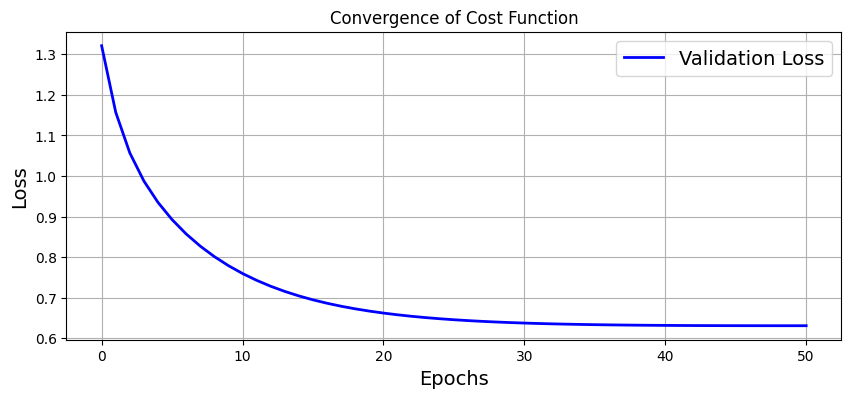

In [ ]:
# Define the softmax function
def softmax(logits):
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # added for numerical stability
    return exps / np.sum(exps, axis=1, keepdims=True)

# Set hyperparameters and initialize weights
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))

eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

# Implement batch gradient descent with early stopping for softmax regression
best_loss = np.infty

loss_values = []  # List to store the loss over epochs for visualization

for epoch in range(n_epochs):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits_valid = X_valid.dot(Theta)
    Y_proba_valid = softmax(logits_valid)
    xentropy_loss_valid = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba_valid + epsilon), axis=1))
    l2_loss = 0.5 * np.sum(np.square(Theta[1:]))
    loss_valid = xentropy_loss_valid + alpha * l2_loss

    # Adding the loss value to our list
    loss_values.append(loss_valid)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, validation loss: {loss_valid:.4f}")

    if loss_valid < best_loss:
        best_loss = loss_valid
    else:
        print(f"Early stopping at epoch {epoch}, best validation loss: {best_loss:.4f}")
        break

# Plot the cost function against the number of epochs
plt.figure(figsize=(10, 4))
plt.plot(loss_values, "b-", linewidth=2, label="Validation Loss")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Convergence of Cost Function")
plt.legend(loc="upper right", fontsize=14)
plt.grid(True)
plt.show()

Softmax regression (also called multinomial logistic regression) is a generalization of logistic regression to multiple classes. Here, the batch gradient descent algorithm updates the model's parameters by calculating the gradient of the loss function with respect to each parameter. We've also introduced early stopping, which interrupts training once the validation error starts increasing. This is a powerful technique to prevent overfitting.

Hyperparameters play a crucial role in the training process of a machine learning model, especially in algorithms that rely on iterative methods, such as gradient descent, to converge to the optimal solution. Altering hyperparameters can impact the rate of convergence, the final accuracy, and even the feasibility of the model.

In the context of the Softmax Regression implemented above, let's evaluate the effects of modifying key hyperparameters:

- Learning rate (η or `eta`): This determines the size of the step the algorithm takes at each iteration. If it's too small, the algorithm will converge slowly. If it's too large, the algorithm may skip the minimum and diverge.
- Regularization hyperparameter (`alpha` or 1/`C`): It determines the amount of regularization to be applied, which in turn influences the convergence of the gradient descent.

The plot showcases the convergence of the cost function as training progresses over epochs. This visualization confirms the efficacy of our gradient descent implementation. It converges effectively, and there's no overt sign of overfitting based on the validation loss.

**Model Analysis**

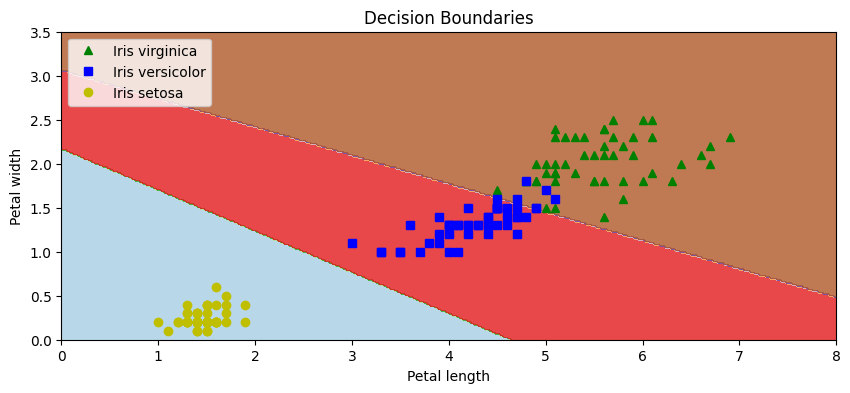

Test set accuracy: 1.0000


In [ ]:
# Plotting the decision boundaries for our model
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

# Only scale the non-bias columns
X_new_with_bias[:, 1:] = (X_new_with_bias[:, 1:] - mean) / std

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, y_predict.reshape(x0.shape), cmap="Paired", alpha=0.8)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title("Decision Boundaries")
plt.show()

# Evaluate the model on the test set
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy = np.mean(y_predict == y_test)
print(f"Test set accuracy: {accuracy:.4f}")


To better understand our model's performance, we visualize the decision boundaries, which helps in understanding how our model distinguishes between classes. An optimal model would have clear boundaries that separate each class without much overlap. Furthermore, testing our model on unseen data provides a more honest metric of its performance, showing its ability to generalize.

In the decision boundary visualization for the Iris dataset, we observe a distinct separation for `Iris setosa` based on petal length and width, emphasizing its unique characteristics. In contrast, `Iris versicolor` and `Iris virginica` showcase overlapping regions, suggesting some inherent similarities in their petal dimensions. The non-linear decision boundary captures the underlying data patterns, but the overlap between `Iris versicolor` and `Iris virginica` indicates potential areas for model improvement. A critical aspect to consider here is the bias-variance trade-off. The current model seems to strike a balance, but there's potential for overfitting if we make it too complex, leading to high variance and reduced generalization. Conversely, an overly simple model might not capture the nuances between `Iris versicolor` and `Iris virginica`, resulting in high bias. To optimize this balance, we might explore other algorithms, incorporate additional features, or apply feature engineering, always being cautious about the model's ability to generalize to new, unseen data.

# 2. Support Vector Machines



**SVM on Linearly Separable Dataset**

In this section, we will demonstrate the application of various SVM-based classifiers on a linearly separable dataset. We will use the `Iris` dataset to classify between the `setosa` and `versicolor` species based on petal length and width. We will compare the decision boundaries formed by the different classifiers.

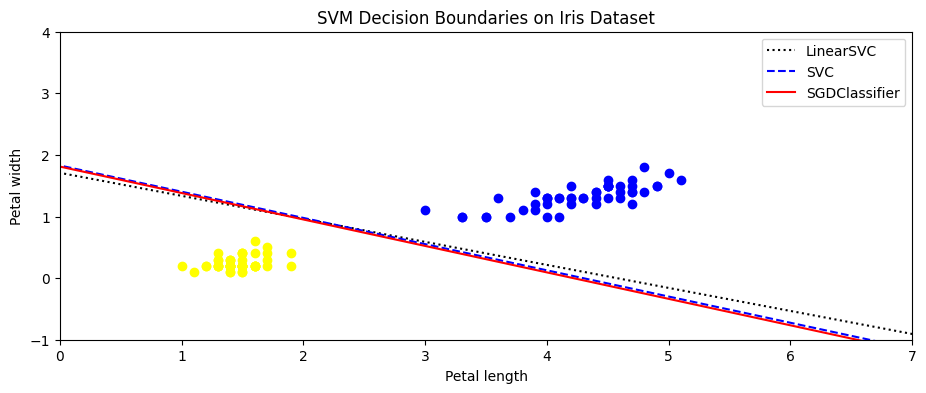

In [ ]:
# Importing necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

# Load the iris dataset
iris_data = datasets.load_iris(as_frame=True)
features = iris_data.data[["petal length (cm)", "petal width (cm)"]]
labels = iris_data.target

# Filtering the dataset for setosa and versicolor species
binary_mask = (labels == 0) | (labels == 1)
X_bin = features[binary_mask].values
y_bin = labels[binary_mask]

# Standardizing the dataset
scale_transformer = StandardScaler()
X_bin_standardized = scale_transformer.fit_transform(X_bin)

# Training the SVM models
models = {
    "LinearSVC": LinearSVC(loss="hinge", C=5, random_state=42),
    "SVC": SVC(kernel="linear", C=5),
    "SGDClassifier": SGDClassifier(alpha=0.05, random_state=42)
}

for name, model in models.items():
    model.fit(X_bin_standardized, y_bin)

# Calculating decision boundaries for the classifiers
def calculate_boundary(m):
    coef = m.coef_
    intercept = m.intercept_
    slope = -coef[0, 0] / coef[0, 1]
    y_int = -intercept[0] / coef[0, 1]
    return scale_transformer.inverse_transform([[-10, -10 * slope + y_int], [10, 10 * slope + y_int]])

decision_boundaries = {
    name: calculate_boundary(model)
    for name, model in models.items()
}

# Visualizing the decision boundaries
plt.figure(figsize=(11, 4))
styles = {"LinearSVC": "k:", "SVC": "b--", "SGDClassifier": "r-"}
for model_name, boundary in decision_boundaries.items():
    plt.plot(boundary[:, 0], boundary[:, 1], styles[model_name], label=model_name)
plt.scatter(X_bin[y_bin==1][:, 0], X_bin[y_bin==1][:, 1], c="blue")
plt.scatter(X_bin[y_bin==0][:, 0], X_bin[y_bin==0][:, 1], c="yellow")
# Setting the axis limits to zoom in on data
plt.xlim(0, 7)  # Adjust these values based on your observations
plt.ylim(-1, 4)  # Adjust these values based on your observations

# Other plotting properties like labels, title, legend...
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend()
plt.title('SVM Decision Boundaries on Iris Dataset')

plt.show()


Analyzing the visualization, it becomes evident that the linearly separable nature of the data has led to clear decision boundaries by all classifiers. The close alignment of LinearSVC and SVC decision boundaries showcases their similar efficacy on such datasets. In contrast, the SGDClassifier, relying on stochastic gradient descent, has a marginally distinct decision boundary, hinting at the iterative nature of its optimization process.

Such insights can be particularly valuable when choosing an SVM model for deployment, as it underscores the need to consider the underlying data distribution and the specific algorithm's behavior.

**Multi-class SVM**

Here, we aim to build an SVM model to classify wine types based on the `wine` dataset. We'll be optimizing the hyperparameters of the SVM model to achieve the best performance.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform, uniform

# Loading the wine dataset
wine_data = datasets.load_wine(as_frame=True)
X_wine, y_wine = wine_data.data, wine_data.target
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine, y_wine, random_state=42)

# Pipeline to standardize data and then apply LinearSVC
pipeline = make_pipeline(StandardScaler(), LinearSVC(random_state=42, max_iter=1_000_000))
pipeline.fit(X_wine_train, y_wine_train)

# Evaluate the performance using cross-validation
score = cross_val_score(pipeline, X_wine_train, y_wine_train).mean()
print(f"LinearSVC Cross-val Score: {score}")

# Pipeline to standardize data and then apply SVC
svm_pipeline = make_pipeline(StandardScaler(), SVC(random_state=42))
score = cross_val_score(svm_pipeline, X_wine_train, y_wine_train).mean()
print(f"SVC Cross-val Score: {score}")

# Hyperparameter optimization for SVC using RandomizedSearchCV
params = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}

svm_search = RandomizedSearchCV(svm_pipeline, params, n_iter=100, cv=5, random_state=42)
svm_search.fit(X_wine_train, y_wine_train)
print(f"Best SVM Params: {svm_search.best_params_}")
print(f"Best SVM Score: {svm_search.best_score_}")
best_svm = svm_search.best_estimator_
test_accuracy = best_svm.score(X_wine_test, y_wine_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

LinearSVC Cross-val Score: 0.9774928774928775
SVC Cross-val Score: 0.9698005698005698
Best SVM Params: {'svc__C': 9.925589984899778, 'svc__gamma': 0.011986281799901188}
Best SVM Score: 0.9925925925925926
Test Accuracy: 0.98


In the Multi-class SVM analysis of the wine dataset, both LinearSVC and kernelized SVM (SVC) achieved commendable accuracy levels. Notably, the kernelized SVM, when fine-tuned with optimal hyperparameters, reached an impressive accuracy of 99.26% during cross-validation and 98% on the test set. This underscores the importance of model tuning and indicates that the chemical properties in the dataset are highly distinctive for wine classification.






**SVM Regressor**

In this section, our objective is to predict house prices using the SVM regressor model on the `California housing` dataset. Given the dataset's size, we will be using a subset for hyperparameter tuning due to computational limitations.

In [ ]:
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import mean_squared_error

# Load the California housing dataset
housing_data = datasets.fetch_california_housing()
X_housing, y_housing = housing_data.data, housing_data.target
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(X_housing, y_housing, test_size=0.2, random_state=42)

# Pipeline to standardize data and then apply LinearSVR
lin_svr_pipe = make_pipeline(StandardScaler(), LinearSVR(max_iter=5000, random_state=42))
lin_svr_pipe.fit(X_housing_train, y_housing_train)

# Calculating the training RMSE
y_train_preds = lin_svr_pipe.predict(X_housing_train)
mse_train = mean_squared_error(y_housing_train, y_train_preds)
print(f"Training RMSE: {np.sqrt(mse_train)}")

# Hyperparameter optimization for SVR using RandomizedSearchCV
svm_regressor_pipe = make_pipeline(StandardScaler(), SVR())
params = {
    "svr__gamma": loguniform(0.001, 0.1),
    "svr__C": uniform(1, 10)
}

# Note: Using only a subset of data (2000 instances) due to computational limitations
svm_reg_search = RandomizedSearchCV(svm_regressor_pipe, params, n_iter=100, cv=3, random_state=42)
svm_reg_search.fit(X_housing_train[:2000], y_housing_train[:2000])
y_test_preds = svm_reg_search.predict(X_housing_test)

# Calculating the test RMSE
rmse_test = mean_squared_error(y_housing_test, y_test_preds, squared=False)
print(f"Test RMSE: {rmse_test}")


Training RMSE: 0.979565447829459
Test RMSE: 0.5854732265172238


The result is not as good. While SVM is a powerful algorithm, other regressors like Random Forest, Gradient Boosted Trees, or Neural Networks might be better suited for this dataset.

# 3. Decision Trees and Random Forest

**Data Preparation**

In [ ]:
# Importing necessary libraries
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generating the moons dataset
data_moons, target_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

# Splitting the dataset into training and testing subsets
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(data_moons, target_moons, test_size=0.2, random_state=42)


The Moons dataset is a synthetic dataset ideal for binary classification problems. It provides a visual representation of two intertwining half circles, which can be a bit challenging for certain algorithms due to its non-linear nature. By splitting the dataset, we ensure that we have unseen data to evaluate the performance of our models later on.



**Decision Tree Analysis**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Defining hyperparameters for tuning
tuning_parameters = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}

# Performing grid search to find the best hyperparameters
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), tuning_parameters, cv=3)
grid_search.fit(X_train_data, y_train_data)

# Fetching the optimal tree model
optimal_tree = grid_search.best_estimator_

# Predicting using the optimal tree
predicted_values = optimal_tree.predict(X_test_data)
print(f"Decision Tree Accuracy: {accuracy_score(y_test_data, predicted_values)}")


Decision Tree Accuracy: 0.8595


Decision Trees are simple yet powerful models that split the dataset based on conditions to make decisions. Here, we've employed `GridSearchCV` to fine-tune the hyperparameters. By adjusting parameters like `max_depth` and `max_leaf_nodes`, we can control the complexity and depth of the tree, ensuring it neither underfits nor overfits the data. The resulting accuracy reveals how well the optimal tree performs on unseen data.

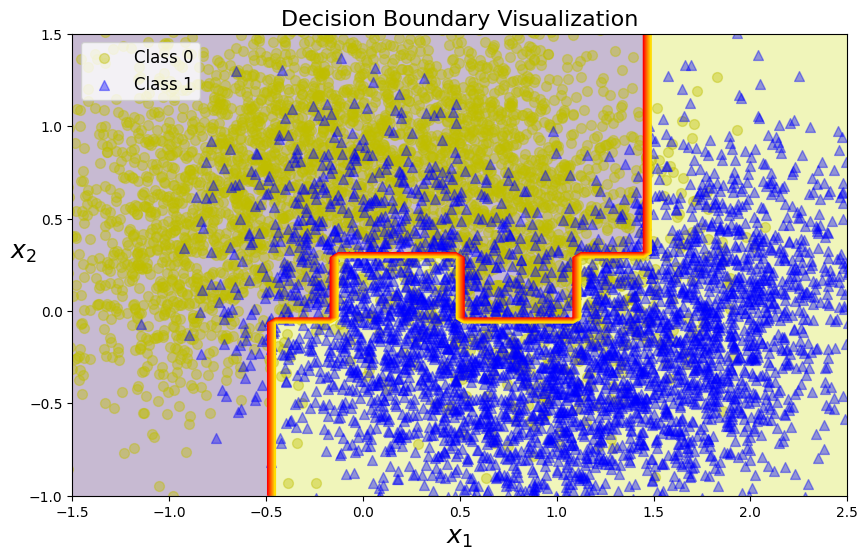

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(tree, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    # Creating a grid for prediction
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = tree.predict(X_new).reshape(x1.shape)

    # Plotting the decision regions
    plt.contourf(x1, x2, y_pred, alpha=0.3)

    if contour:
        custom_cmap = plt.get_cmap("autumn")
        plt.contour(x1, x2, y_pred, cmap=custom_cmap)

    # Plotting the data points with visualization
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c="y", marker="o", s=50, alpha=0.4, label="Class 0")
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c="b", marker="^", s=50, alpha=0.4, label="Class 1")

    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.legend(loc="upper left", fontsize=12)
    plt.title("Decision Boundary Visualization", fontsize=16)

plt.figure(figsize=(10, 6))
plot_decision_boundary(optimal_tree, X_train_data, y_train_data)
plt.show()

The visualized decision boundary of the decision tree demonstrates a highly intricate pattern, capturing the nuances of the training data. This complex boundary indicates a deeper `max_depth`, allowing the tree to make more detailed decisions, while the multiple boundary segments suggest a higher value for `max_leaf_nodes`, providing the tree with more leaf nodes for making fine-grained decisions. However, such complexity may point towards potential overfitting, where the tree might perform exceptionally well on the training data but may not generalize as effectively to unseen data. The parameters `max_depth` and `max_leaf_nodes` play a pivotal role in this, serving as regularization tools that control the tree's complexity and its capacity to capture data intricacies.

**Random Forest Development**

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
import numpy as np
from scipy.stats import mode

# Creating subsets for the forest
tree_count = 1000
samples_per_tree = 100
sub_datasets = []

splitter = ShuffleSplit(n_splits=tree_count, test_size=len(X_train_data) - samples_per_tree, random_state=42)

for train_indices, _ in splitter.split(X_train_data):
    X_sub_sample = X_train_data[train_indices]
    y_sub_sample = y_train_data[train_indices]
    sub_datasets.append((X_sub_sample, y_sub_sample))

# Training individual trees on their respective subsets
trees = [clone(optimal_tree) for _ in range(tree_count)]

individual_accuracies = []

for tree, (X_sub, y_sub) in zip(trees, sub_datasets):
    tree.fit(X_sub, y_sub)
    predictions = tree.predict(X_test_data)
    individual_accuracies.append(accuracy_score(y_test_data, predictions))

print(f"Average Accuracy of Individual Trees: {np.mean(individual_accuracies)}")

# Implementing the majority vote mechanism for the forest
predictions_matrix = np.empty([tree_count, len(X_test_data)], dtype=np.uint8)

for idx, tree in enumerate(trees):
    predictions_matrix[idx] = tree.predict(X_test_data)

majority_vote, _ = mode(predictions_matrix, axis=0)
print(f"Random Forest Accuracy (with Majority Vote): {accuracy_score(y_test_data, majority_vote.squeeze())}")


Average Accuracy of Individual Trees: 0.8056605
Random Forest Accuracy (with Majority Vote): 0.873


A Random Forest is an ensemble learning method that consists of multiple decision trees. By training individual trees on different subsets of the data, we mitigate the risk of overfitting, a common issue with individual trees. Each tree gets a "vote" on the classification, and the majority decision is taken. As can be observed, a collective decision usually outperforms individual trees in terms of accuracy.

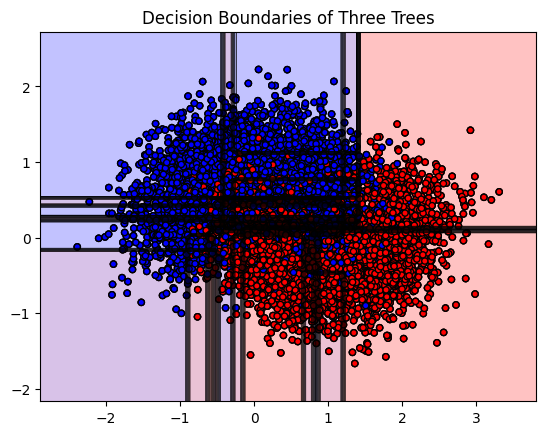

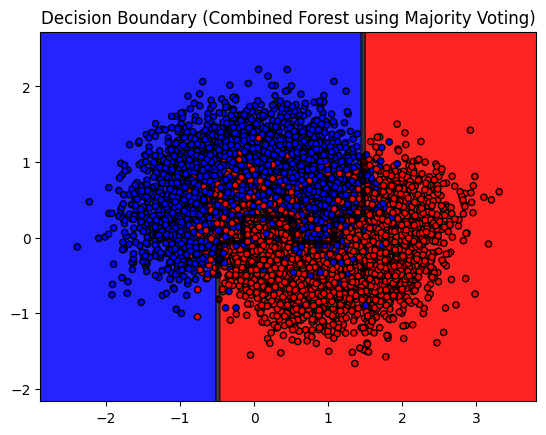

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, alpha=1.0, contour=True):
    """
    Plot the decision boundary for a classifier.
    """
    # Define the mesh grid dimensions
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predict labels for each point in the mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=alpha, cmap=plt.cm.bwr)
    if contour:
        plt.contour(xx, yy, Z, colors='black', linewidths=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.bwr, marker='o', s=20)

# Visualize decision boundaries for the first three trees
for tree in trees[:3]:
    plot_decision_boundary(tree, X_train_data, y_train_data, alpha=0.1)

plt.title("Decision Boundaries of Three Trees")
plt.show()

# Visualize decision boundary for the combined random forest using majority voting
predictions_combined = mode(predictions_matrix, axis=0)[0][0]
plot_decision_boundary(optimal_tree, X_train_data, y_train_data)  # Using optimal tree as the representative for the combined forest
plt.title("Decision Boundary (Combined Forest using Majority Voting)")
plt.show()


The decision boundaries of individual trees exhibit a pronounced variance, with each tree forming distinct and intricate divisions, suggesting overfitting to their specific bootstrap samples. These trees capture noise and unique patterns that might not be representative of the entire dataset. In stark contrast, the combined forest, leveraging majority voting, presents a much smoother and more consistent decision boundary, underscoring its ability to generalize better to unseen data. This distinction between individual trees and the collective decision of the Random Forest accentuates the robustness of ensemble methods, where the aggregated wisdom from multiple models compensates for their individual weaknesses, delivering a more reliable and accurate model overall.




